# Adding noise to original data

This notebook contains three experiments:

* Experiment #1: **Generating dataset based on gaussian random data and adding uniform noise**
 - In this experiment we create original set of data based on **gaussian** random data and we **add non gaussian noise (uniform)** to it at the zones where uncertainty is lower. The expected behaviour is in those areas the uncertanty must increase and decrease again after them. We don't know exactly how to increase and decrease or what values it will show, so we don't have validation data.

* Experiment #2: **Generating dataset based on uniform random data and adding uniform noise**
 - In this experiment we create a set of data like original, but based on **uniform** random data **add non gaussian noise (uniform)** to training data at the zones where uncertainty is lower. The expected behaviour is in those areas the uncertanty must increase and decrease again after them. We don't know exactly how to increase and decrease or what values it will show, so we don't have validation data.
    
* Experiment #3: **Adding non gaussian noise using uniform distribution**
 - This experiment uses the original data generation, but replicates the previous experiments steps, like no data splitting.

And a general conclussions section.

Warning: The design of these experiments has flaws, mixing data with noise without marking it, so model deal with all data as equal kind of data. Besides, there are not quantiative expectations, making cualitatives conclussions prone to bias.

You can see the initial experiment reproduction at "initial validation" in this repository.

Original at: https://github.com/sthorn/deep-learning-explorations/blob/master/predicting-uncertainty.ipynb

## Experiment #1

**Generating dataset based on gaussian random data and adding uniform noise**
In this experiment we create original set of data based on **gaussian** random data and we **add non gaussian noise (uniform)** to it at the zones where uncertainty is lower. The expected behaviour is in those areas the uncertanty must increase and decrease again after them. We don't know exactly how to increase and decrease or what values it will show, so we don't have validation data.

### Imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as m
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import copy

%matplotlib inline

### Generate some random data

Now we generate the same training data than the original experiment, using gaussian distribution for eps.

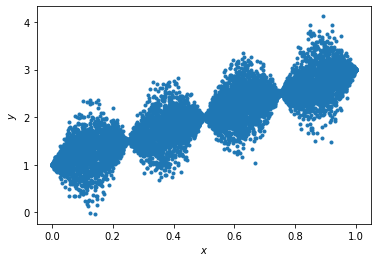

In [2]:
# Generate some linearly related data
n_samples = 10000
np.random.seed(4567)
x = np.random.random(n_samples)
eps = np.random.normal(scale=1.0, size=n_samples) * 0.4*np.sin(x*4*np.pi)
y = 2*x + 1  + eps
plt.plot(x, y, '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

Then we generate the noise to add. This noise is going to be added at the minimum of the sines shapes. 
There are three zones of noise. 
The initial two ones are in near minimums, while the third is further away, at the end of the data. This way we can see the behaviour with several ditances between noise blocks.
The noise is used as multiplier for data, the rest are ones to maintain original data.

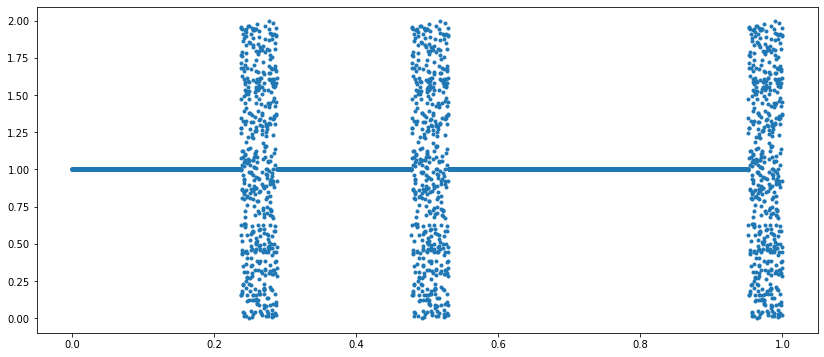

In [3]:
#generate noise
min_noise = 0
max_noise = 2
n_noise_samples=500 #5% of samples
#offset to locate noise 
offset=int((n_samples-n_noise_samples)/2)
#padding_zeros=np.zeros(int((n_samples-n_noise_samples)/2),dtype=float)
partial_non_gaussian_noise = np.random.uniform(min_noise, max_noise, n_noise_samples)
#nonGaussianNoise=np.concatenate((padding_zeros, partialNonGaussianNoise,padding_zeros))
non_gaussian_noise=np.ones(n_samples)
#x is a non-ordered array. In order to locate noise at a selected point, we need to order x and assing the y.
ordered_x=copy.deepcopy(x)
#ordered_x=x
ordered_x.sort()

for ordered_position in range(n_noise_samples):
    value_to_find=ordered_x[ordered_position+offset]
    original_array_position=np.where(x==value_to_find)[0]
    non_gaussian_noise[original_array_position]=partial_non_gaussian_noise[ordered_position]

for ordered_position in range(n_noise_samples):
    value_to_find=ordered_x[ordered_position+int(offset/2)]
    original_array_position=np.where(x==value_to_find)[0]
    non_gaussian_noise[original_array_position]=partial_non_gaussian_noise[ordered_position]

for ordered_position in range(n_noise_samples):
    value_to_find=ordered_x[ordered_position+int(2*offset)]
    original_array_position=np.where(x==value_to_find)[0]
    non_gaussian_noise[original_array_position]=partial_non_gaussian_noise[ordered_position]
plt.figure(figsize=(14,6))
plt.plot(x,non_gaussian_noise, '.')

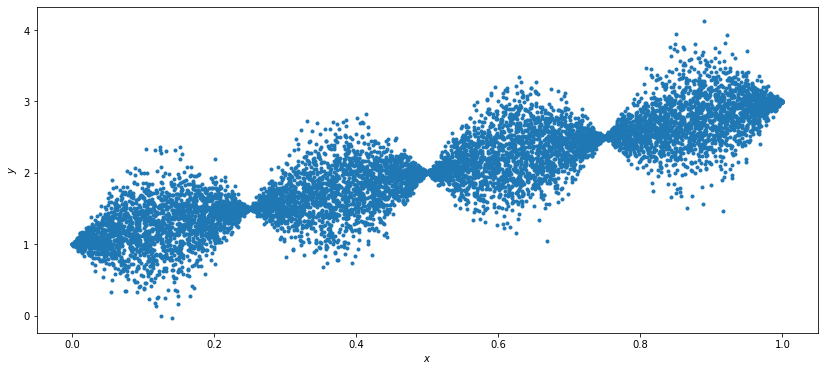

In [4]:
# Plot the original data
plt.figure(figsize=(14,6))
plt.plot(x, y, '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

At this point we add original data and noise blocks, so we have training data of the experiment.

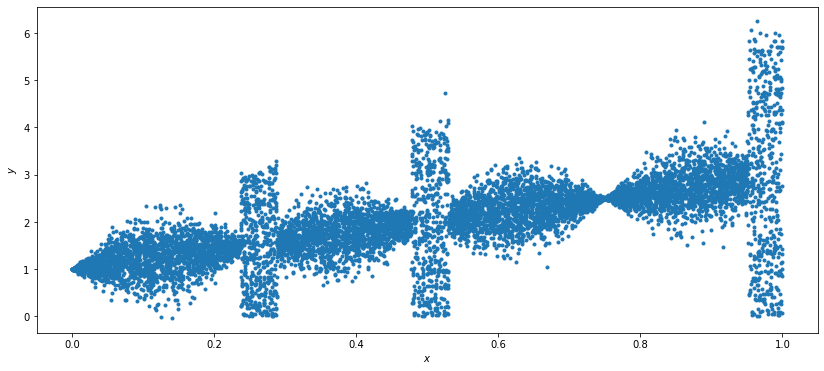

In [5]:
#add noise
y = y * non_gaussian_noise
# Plot the data
plt.figure(figsize=(14,6))
plt.plot(x, y, '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [6]:
# Add in column of dummy zeros to represent sigma 
sigma = np.zeros(10000)
y = np.stack([y, sigma], axis=1)

In [7]:
# Reshape x for PyTorch
x = x.reshape(10000, 1)

In [8]:
# Split into training and validation sets
n_validation = 500
x_val, x = x[:n_validation], x[n_validation:]
y_val, y = y[:n_validation], y[n_validation:]

In [9]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.FloatTensor
x = Variable(torch.from_numpy(x).type(dtype))
y = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)

In [10]:
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x.shape, y.shape

(torch.Size([9500, 1]), torch.Size([9500, 2]))

### Create a simple network 

In [11]:
# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
n_inputs = 1
n_outputs = 2
n_hidden = 1000
model = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_hidden, n_outputs)
                           )

In [12]:
# Adam optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Custom loss function
This is where the magic happens.

In [13]:
def custom_loss(input, target):
    
    # Estimate target value for sigma with abs(y_pred - y)
    #
    #    actual y     is target[:,0]
    # predicted y     is input[:,0]
    #    actual sigma is target[:,1]
    # predicted sigma is input[:,1]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data).abs(), 
                           requires_grad=False)  
    # Return MSE loss 
    return F.mse_loss(input, target)

### Training loop 
We train this simple model with batch size equal to the whole dataset.

In [14]:
y_pred = model(x)
custom_loss(y_pred,y)

tensor(4.7073, grad_fn=<MseLossBackward>)

In [15]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model(x)
    
    # Calculate loss
    loss = custom_loss(y_pred, y)
    loss
    if i%500 == 0: print(f'epoch: {i:4}, loss: {loss.data:.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0, loss: 4.71
epoch:  500, loss: 0.269
epoch: 1000, loss: 0.263
epoch: 1500, loss: 0.259
epoch: 2000, loss: 0.256
epoch: 2500, loss: 0.254
epoch: 3000, loss: 0.252
epoch: 3500, loss: 0.25
epoch: 4000, loss: 0.249
epoch: 4500, loss: 0.247
epoch: 5000, loss: 0.246
epoch: 5500, loss: 0.244
epoch: 6000, loss: 0.243
epoch: 6500, loss: 0.242
epoch: 7000, loss: 0.241
epoch: 7500, loss: 0.24
epoch: 8000, loss: 0.239
epoch: 8500, loss: 0.238
epoch: 9000, loss: 0.238
epoch: 9500, loss: 0.237


### Get predictions 

We use x_val in order to make a readable plot, there is no data splitting to training and validation.

In [16]:
# Get predicted y and sigma
x_val = Variable(torch.from_numpy(x_val).type(dtype)) 
pred = model(x_val)
y_pred = pred[:,0].cpu().data
sigma_pred = pred[:,1].cpu().data

### Plot results

We use x_val in order to make a readable plot, there is no data splitting to training and validation.

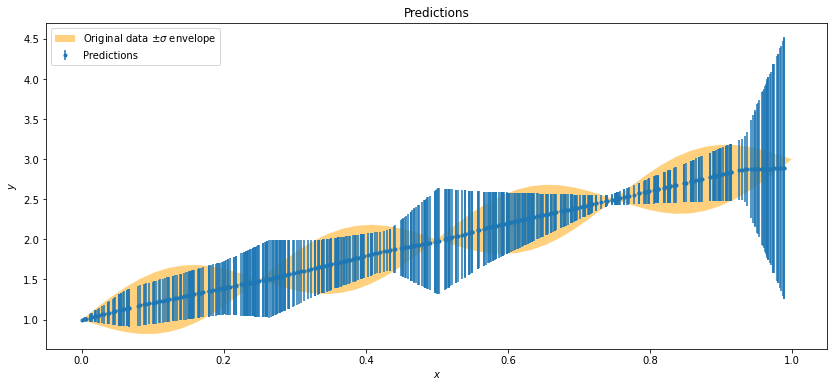

In [17]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))
plt.errorbar(x_val, y_pred, yerr=sigma_pred, fmt='.');
#plt.errorbar(x_val, y_pred, fmt='.');
# One standard-deviation envelope
xs = np.linspace(0.0, 1.0, 50)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Predictions'], loc='upper left', );

So, as expected, uncertainty is increased in zones were noise is added and it is reduced again in zones between noise. 
Since we are predicting a point (mean) and uncertainty (variance), the model seems being trying to fit data into gaussians distributions.

However, we don't know exactly how this happens, so experiment is inconclusive about its behaviour in other environments.

Now we calculate an R2 metric in order to compare with next experiments.

In [18]:
m.r2_score(y_val[:,0],y_pred)

0.4972693997081953

## Experiment #2

**Generating data  set based on uniform random data and adding uniform noise**
 - In this experiment we create a set of data like original, but based on **uniform** random data **add non gaussian noise (uniform)** to training data at the zones where uncertainty is lower. The expected behaviour is in those areas the uncertanty must increase and decrease again after them. We don't know exactly how to increase and decrease or what values it will show, so we don't have validation data.
 
We changed how signal is generated in order to compare how it affects to uncertainty prediction.


**You must restart the notebook kernel**

### Imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as m
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import copy

%matplotlib inline

### Generate some random data

This time eps is generated using an uniform distribution instead of a normal one.

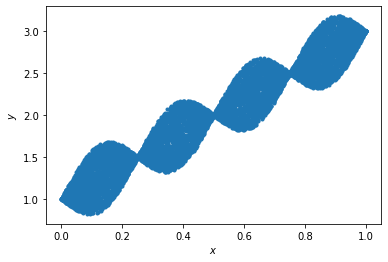

In [2]:
# Generate some linearly related data
n_samples = 10000
np.random.seed(4567)
x = np.random.random(n_samples)
eps = np.random.uniform(low=-1.0, high=1.0, size=n_samples) * 0.4*np.sin(x*4*np.pi)
#eps = np.random.normal(scale=1.0, size=n_samples) * 0.4*np.sin(x*4*np.pi)
y = 2*x + 1  + eps
plt.plot(x, y, '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

We generate noise in the same way than the experiment #1, matching noise with low uncertainty zones.

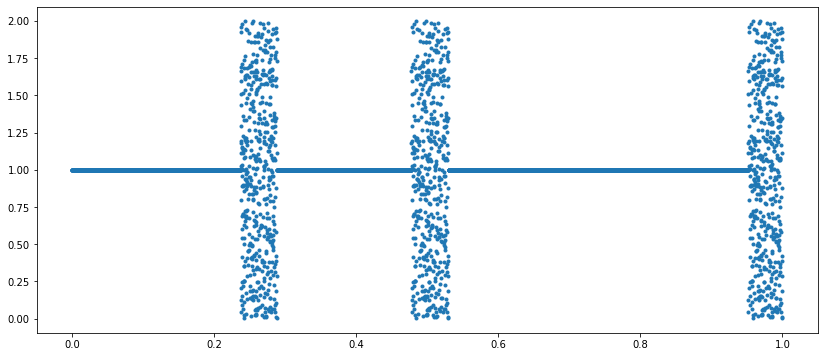

In [3]:
#generate noise
k_noise = 0
theta_noise = 2
n_noise_samples=500 #5% of samples
#offset to locate noise 
offset=int((n_samples-n_noise_samples)/2)
#padding_zeros=np.zeros(int((n_samples-n_noise_samples)/2),dtype=float)
partial_non_gaussian_noise = np.random.uniform(k_noise, theta_noise, n_noise_samples)
#nonGaussianNoise=np.concatenate((padding_zeros, partialNonGaussianNoise,padding_zeros))
non_gaussian_noise=np.ones(n_samples)
#x is a non-ordered array. In order to locate noise at a selected point, we need to order x and assign the y.
ordered_x=copy.deepcopy(x)
#ordered_x=x
ordered_x.sort()

for ordered_position in range(n_noise_samples):
    value_to_find=ordered_x[ordered_position+offset]
    original_array_position=np.where(x==value_to_find)[0]
    non_gaussian_noise[original_array_position]=partial_non_gaussian_noise[ordered_position]

for ordered_position in range(n_noise_samples):
    value_to_find=ordered_x[ordered_position+int(offset/2)]
    original_array_position=np.where(x==value_to_find)[0]
    non_gaussian_noise[original_array_position]=partial_non_gaussian_noise[ordered_position]

for ordered_position in range(n_noise_samples):
    value_to_find=ordered_x[ordered_position+int(2*offset)]
    original_array_position=np.where(x==value_to_find)[0]
    non_gaussian_noise[original_array_position]=partial_non_gaussian_noise[ordered_position]
plt.figure(figsize=(14,6))
plt.plot(x,non_gaussian_noise, '.')

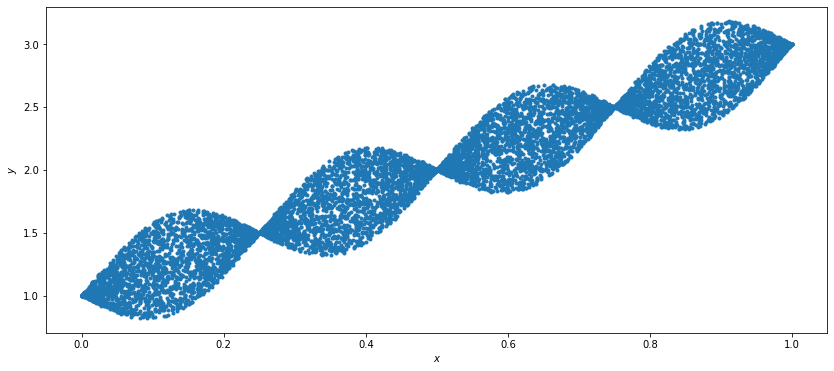

In [4]:
# Plot the data
plt.figure(figsize=(14,6))
plt.plot(x, y, '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

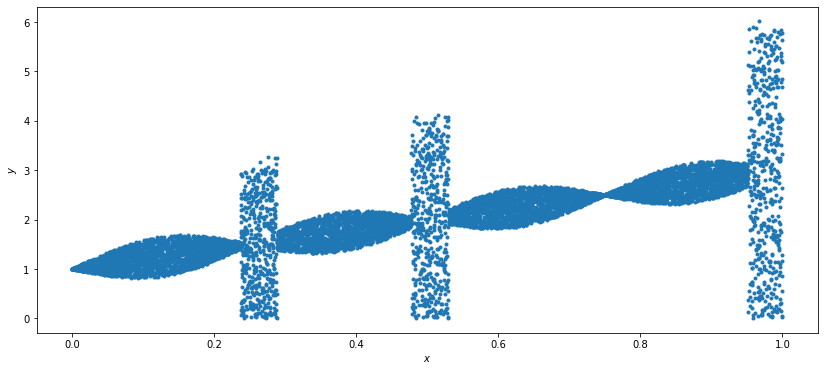

In [5]:
#add noise
y = y * non_gaussian_noise
# Plot the data
plt.figure(figsize=(14,6))
plt.plot(x, y, '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [6]:
# Add in column of dummy zeros to represent sigma 
sigma = np.zeros(10000)
y = np.stack([y, sigma], axis=1)

In [7]:
# Reshape x for PyTorch
x = x.reshape(10000, 1)

In [8]:
# Split into training and validation sets
n_validation = 500
x_val, x = x[:n_validation], x[n_validation:]
y_val, y = y[:n_validation], y[n_validation:]

In [9]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.FloatTensor
x = Variable(torch.from_numpy(x).type(dtype))
y = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)

In [10]:
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x.shape, y.shape

(torch.Size([9500, 1]), torch.Size([9500, 2]))

### Create a simple network 

In [11]:
# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
n_inputs = 1
n_outputs = 2
n_hidden = 1000
model = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_hidden, n_outputs)
                           )

In [12]:
# Adam optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Custom loss function
This is where the magic happens.

In [13]:
def custom_loss(input, target):
    
    # Estimate target value for sigma with abs(y_pred - y)
    #
    #    actual y     is target[:,0]
    # predicted y     is input[:,0]
    #    actual sigma is target[:,1]
    # predicted sigma is input[:,1]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data).abs(), 
                           requires_grad=False)  
    # Return MSE loss 
    return F.mse_loss(input, target)

### Training loop 
We train this simple model with batch size equal to the whole dataset.

In [14]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model(x)
    
    # Calculate loss
    loss = custom_loss(y_pred, y)
    
    if i%500 == 0: print(f'epoch: {i:4}, loss: {loss.data:.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0, loss: 4.65
epoch:  500, loss: 0.228
epoch: 1000, loss: 0.223
epoch: 1500, loss: 0.218
epoch: 2000, loss: 0.215
epoch: 2500, loss: 0.213
epoch: 3000, loss: 0.211
epoch: 3500, loss: 0.209
epoch: 4000, loss: 0.207
epoch: 4500, loss: 0.205
epoch: 5000, loss: 0.203
epoch: 5500, loss: 0.202
epoch: 6000, loss: 0.2
epoch: 6500, loss: 0.199
epoch: 7000, loss: 0.197
epoch: 7500, loss: 0.196
epoch: 8000, loss: 0.195
epoch: 8500, loss: 0.194
epoch: 9000, loss: 0.193
epoch: 9500, loss: 0.192


### Get predictions

We use x_val in order to make a readable plot, there is no data splitting to training and validation.

In [15]:
# Get predicted y and sigma
x_val = Variable(torch.from_numpy(x_val).type(dtype))
pred = model(x_val)
y_pred = pred[:,0].cpu().data
sigma_pred = pred[:,1].cpu().data

### Plot results

We use x_val in order to make a readable plot, there is no data splitting to training and validation.

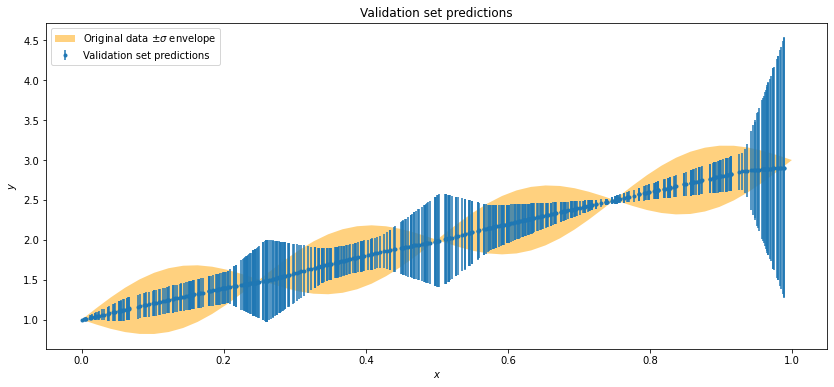

In [16]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))
plt.errorbar(x_val, y_pred, yerr=sigma_pred, fmt='.');
#plt.errorbar(x_val, y_pred, fmt='.');
# One standard-deviation envelope
xs = np.linspace(0.0, 1.0, 50)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );

The model still tries to model the zones as gaussian curves, but this time it seems the low uncertainty zones has a bigger weight than other with higher uncertanity of original data. The model tries to fit the high uncertainty zones of noise and the lower uncertainty zones of data, loosing weight the highr zones of uncertaninty of data. This way, the area uncover of initial uncertantity is bigger than in experiment #1.

Now we calculate an R2 metric in order to compare with the others expriments:

In [18]:
m.r2_score(y_val[:,0],y_pred)


0.4984050040723472

## Experiment #3

**Adding non gaussian noise using uniform distribution**
 - This is the original experiment in order to get an R2 metric to compare with previous experiments.
 
**You must restart the notebook kernel**

Now we will repeat the same experiment but this time all the noise we add is going to be 
from a uniform distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as m
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import copy

%matplotlib inline

We generate the data like in original experiment.

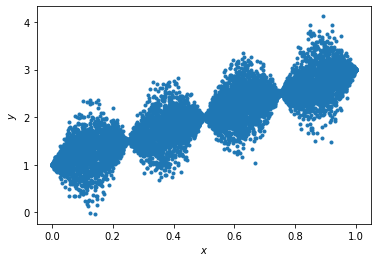

In [3]:
# Generate some linearly related data
n_samples = 10000
np.random.seed(4567)
x = np.random.random(n_samples)
#eps = np.random.uniform(low=-2.0, high=2.0, size=n_samples) * 0.4*np.sin(x*4*np.pi)
eps = np.random.normal(scale=1.0, size=n_samples) * 0.4*np.sin(x*4*np.pi)
y = 2*x + 1  + eps
plt.plot(x, y, '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [4]:
# Add in column of dummy zeros to represent sigma 
sigma = np.zeros(10000)
y = np.stack([y, sigma], axis=1)

In [5]:
# Reshape x for PyTorch
x = x.reshape(10000, 1)

In [6]:
# Split into training and validation sets
n_validation = 500
x_val, x = x[:n_validation], x[n_validation:]
y_val, y = y[:n_validation], y[n_validation:]

In [7]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.FloatTensor
x = Variable(torch.from_numpy(x).type(dtype))
y = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)

In [8]:
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x.shape, y.shape

(torch.Size([9500, 1]), torch.Size([9500, 2]))

### Create a simple network 

In [9]:
# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
n_inputs = 1
n_outputs = 2
n_hidden = 1000
model = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_hidden, n_outputs)
                           )

In [10]:
# Adam optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Custom loss function
This is where the magic happens.

In [11]:
def custom_loss(input, target):
    
    # Estimate target value for sigma with abs(y_pred - y)
    #
    #    actual y     is target[:,0]
    # predicted y     is input[:,0]
    #    actual sigma is target[:,1]
    # predicted sigma is input[:,1]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data).abs(), 
                           requires_grad=False)  
    # Return MSE loss 
    return F.mse_loss(input, target)

### Training loop 
We train this simple model with batch size equal to the whole dataset.

In [12]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model(x)
    
    # Calculate loss
    loss = custom_loss(y_pred, y)
    
    if i%500 == 0: print(f'epoch: {i:4}, loss: {loss.data:.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0, loss: 5.2
epoch:  500, loss: 0.0625
epoch: 1000, loss: 0.0616
epoch: 1500, loss: 0.0614
epoch: 2000, loss: 0.0611
epoch: 2500, loss: 0.0608
epoch: 3000, loss: 0.0605
epoch: 3500, loss: 0.0602
epoch: 4000, loss: 0.0599
epoch: 4500, loss: 0.0597
epoch: 5000, loss: 0.0594
epoch: 5500, loss: 0.0591
epoch: 6000, loss: 0.0587
epoch: 6500, loss: 0.0584
epoch: 7000, loss: 0.0581
epoch: 7500, loss: 0.0577
epoch: 8000, loss: 0.0574
epoch: 8500, loss: 0.0572
epoch: 9000, loss: 0.0569
epoch: 9500, loss: 0.0568


### Get predictions

We use x_val in order to make a readable plot, there is no data splitting to training and validation.

In [13]:
# Get predicted y and sigma
x_val = Variable(torch.from_numpy(x_val).type(dtype))
pred = model(x_val)
y_pred = pred[:,0].cpu().data
sigma_pred = pred[:,1].cpu().data

### Plot results

We use x_val in order to make a readable plot, there is no data splitting into training and validation.

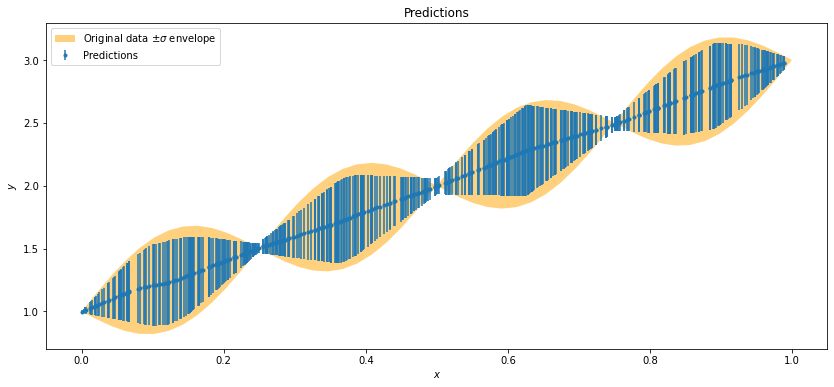

In [14]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))
plt.errorbar(x_val, y_pred, yerr=sigma_pred, fmt='.');
#plt.errorbar(x_val, y_pred, fmt='.');
# One standard-deviation envelope
xs = np.linspace(0.0, 1.0, 50)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Predictions'], loc='upper left', );

Finally, we make an R2 metric in order to compare with the other experiments.

In [15]:
m.r2_score(y_val[:,0],y_pred)




0.8008535741672906

## Overall conclussions



The R2 metrics for each experiment are:
    Experiment 1: 0.4972693997081953
    Experiment 2: 0.4984050040723472
    Experiment 3: 0.8008535741672906
        
So, the conclussions are:
* The kind of noise doesnt affect to results
* The model tries to fit in gaussians curves. Since it tries to get a mean and a variance it is expected.